In [50]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt


%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.applications.mobilenet_v2 import MobileNetV2

from IPython.display import HTML
from base64 import b64encode

In [3]:
def Play_Video(filepath):
    html = ''
    video = open(filepath, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [5]:
NonViolnceVideos_Dir = "D:/VIOLENCE_DATASET/Real Life Violence Dataset/NonViolence"
ViolnceVideos_Dir = "D:/VIOLENCE_DATASET/Real Life Violence Dataset/Violence"

In [6]:
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

In [7]:
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [8]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

In [9]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

In [10]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16

In [12]:
DATASET_DIR = "D:/VIOLENCE_DATASET/real life violence situations/Real Life Violence Dataset"

In [13]:
CLASSES_LIST = ["NonViolence", "Violence"]

In [14]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [15]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [16]:
features, labels, video_files_paths = create_dataset()
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_files_paths)

Extracting Data of Class: NonViolence
Extracting Data of Class: Violence


In [17]:
features, labels, video_files_paths = np.load("features.npy"), np.load("labels.npy"), np.load("video_files_paths.npy")

In [18]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.1,
                                                                            shuffle=True, random_state=42)

In [19]:
print(features_train.shape, labels_train.shape)
print(features_test.shape, labels_test.shape)

(1800, 16, 64, 64, 3) (1800, 2)
(200, 16, 64, 64, 3) (200, 2)


In [20]:
mobilenet = MobileNetV2(include_top=False, weights="imagenet")
mobilenet.trainable = True

In [21]:
for layer in mobilenet.layers[:-40]:
    layer.trainable = False

In [22]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(mobilenet))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards=True)
    model.add(Bidirectional(lstm_fw, backward_layer=lstm_bw))

    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()
    return model

In [23]:
MoBiLSTM_model = create_model()
plot_model(MoBiLSTM_model, to_file='MobBiLSTM_model_structure_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 2, 2, 1280)   2257984   
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 5120)         0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               1319168   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [24]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, min_lr=0.00005, verbose=1)

In [25]:
MoBiLSTM_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])
MobBiLSTM_model_history = MoBiLSTM_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=8,
                                             shuffle=True, validation_split=0.2,
                                             callbacks=[early_stopping_callback, reduce_lr])


Epoch 1/50
180/180 [==============================] - 36s 109ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6890 - val_accuracy: 0.5806 - lr: 0.0100
Epoch 2/50
180/180 [==============================] - 17s 96ms/step - loss: 0.6912 - accuracy: 0.5215 - val_loss: 0.6870 - val_accuracy: 0.5861 - lr: 0.0100
Epoch 3/50
180/180 [==============================] - 17s 96ms/step - loss: 0.6876 - accuracy: 0.5243 - val_loss: 0.6748 - val_accuracy: 0.6389 - lr: 0.0100
Epoch 4/50
180/180 [==============================] - 17s 96ms/step - loss: 0.6734 - accuracy: 0.5681 - val_loss: 0.6375 - val_accuracy: 0.7167 - lr: 0.0100
Epoch 5/50
180/180 [==============================] - 17s 96ms/step - loss: 0.5974 - accuracy: 0.7083 - val_loss: 0.4663 - val_accuracy: 0.8444 - lr: 0.0100
Epoch 6/50
180/180 [==============================] - 17s 96ms/step - loss: 0.4934 - accuracy: 0.7951 - val_loss: 0.3346 - val_accuracy: 0.8667 - lr: 0.0100
Epoch 7/50
180/180 [==============================] - 17s

In [26]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

7/7 [==============================] - 4s 78ms/step - loss: 0.1265 - accuracy: 0.9500


In [27]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

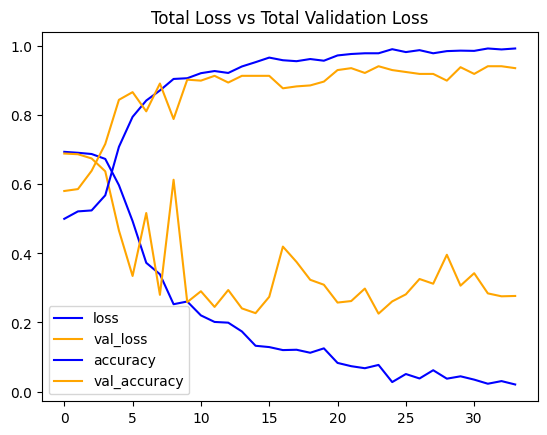

In [28]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [29]:
labels_predict = MoBiLSTM_model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(labels_test, axis=1)

7/7 [==============================] - 3s 72ms/step


In [30]:
from sklearn.metrics import accuracy_score

AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.95


[Text(0, 0.5, 'NonViolence'), Text(0, 1.5, 'Violence')]

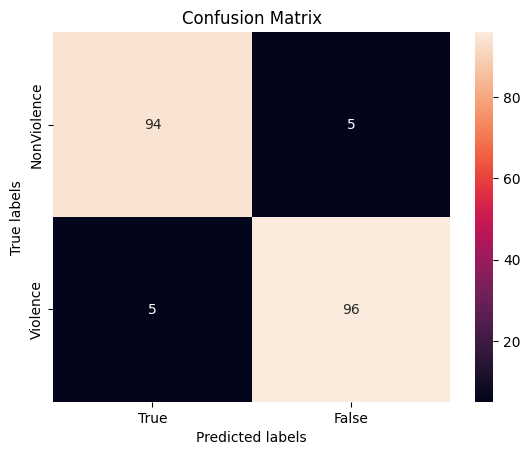

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])

In [32]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal, labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        99
           1       0.95      0.95      0.95       101

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



In [47]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

plt.style.use("default")

In [46]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('my_model_2.h5')

video_path = "D:/DCSASS Dataset/Fighting/Fighting013_x264.mp4"

cap = cv2.VideoCapture(video_path)

# Create a buffer to store a sequence of frames
frame_buffer = []

while cap.isOpened():
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        break

    # Preprocess the frame (resize, normalize, etc.)
    frame = cv2.resize(frame, (64, 64))  # Resize to match the model's input size
    frame = frame / 255.0

    # Add the preprocessed frame to the buffer
    frame_buffer.append(frame)

    # Maintain the buffer size to the desired sequence length
    if len(frame_buffer) > 16:
        frame_buffer.pop(0)

    # Check if the buffer has reached the desired sequence length
    if len(frame_buffer) == 16:
        # Convert the frame buffer to a numpy array and add batch dimension
        input_sequence = np.expand_dims(np.array(frame_buffer), axis=0)

        # Make prediction
        prediction = model.predict(input_sequence)

        # Check if the sequence is abnormal (you might need to adjust the threshold)
        if prediction[0][0] > 0.5:
            # Draw red text on the frame
            cv2.putText(frame, 'Abnormal', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Display the frame with OpenCV
        cv2.imshow('Video', frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Release the video capture object and close the OpenCV window
cap.release()
cv2.destroyAllWindows()


In [42]:
def show_pred_frames(pred_video_path):
    plt.figure(figsize=(20, 15))
    video_reader = cv2.VideoCapture(pred_video_path)
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    random_range = sorted(random.sample(range(SEQUENCE_LENGTH, min(SEQUENCE_LENGTH + 12, frames_count + 1)), 12))


    for counter, random_index in enumerate(random_range, 1):
        plt.subplot(5, 4, counter)
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
        ok, frame = video_reader.read()

        if not ok:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        ax.figure.set_size_inches(20, 20)
        plt.tight_layout()

    video_reader.release()

In [35]:
MoBiLSTM_model.save("my_model_2.h5")

In [40]:
test_videos_directory = 'D:/violence_detection'
os.makedirs(test_videos_directory, exist_ok=True)
output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

In [48]:
input_video_file_path = "D:/DCSASS Dataset/Fighting/Fighting013_x264.mp4"
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
#show_pred_frames(output_video_file_path)
#Play_Video(input_video_file_path)

In [ ]:
input_video_file_path = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_120.mp4"
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
show_pred_frames(output_video_file_path)
Play_Video(input_video_file_path)

In [51]:
def predict_video(video_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_list = []
    predicted_class_name = ''
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_list, axis=0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    video_reader.release()

In [53]:
#!pip install pytube

from pytube import YouTube

def predict_video_from_url(video_url, sequence_length=16):
    try:
        # Get YouTube video details using pytube
        youtube_video = YouTube(video_url)
        video_stream = youtube_video.streams.filter(file_extension="mp4").first()
        video_stream_url = video_stream.url

        # Perform prediction on the video
        predict_video(video_stream_url, sequence_length)

    except Exception as e:
        print(f"Error: {e}")

In [58]:
# Test the user video URL prediction function
user_video_url = "https://www.youtube.com/shorts/LSQ96F878Bk"
predict_video_from_url(user_video_url)

1/1 [==============================] - 0s 31ms/step
Predicted: Violence
Confidence: 0.9654337763786316


In [63]:
user_video_url = "https://www.youtube.com/shorts/jxyLOQPqoXE"
predict_video_from_url(user_video_url)

1/1 [==============================] - 0s 28ms/step
Predicted: Violence
Confidence: 0.9522215127944946


In [3]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the pre-trained model
MoBiLSTM_model = load_model('my_model_2.h5')

# Constants
SEQUENCE_LENGTH = 16  # Adjust this based on your model's requirements
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

def predict_webcam(SEQUENCE_LENGTH):
    # Open a connection to the webcam (typically 0 for built-in webcam)
    webcam = cv2.VideoCapture(0)

    frames_list = []

    while True:
        # Capture frame from the webcam
        ret, frame = webcam.read()

        # Preprocess the frame
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_list.append(normalized_frame)

        # Keep the list size within the sequence length
        if len(frames_list) > SEQUENCE_LENGTH:
            frames_list.pop(0)

        # Check if enough frames have been captured
        if len(frames_list) == SEQUENCE_LENGTH:
            # Make prediction
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_list, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

            # Display the prediction on the frame
            if predicted_class_name == "Violence":
                cv2.putText(frame, f"Predicted: {predicted_class_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            else:
                cv2.putText(frame, f"Predicted: {predicted_class_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            

        # Display the frame
        cv2.imshow('Webcam', frame)

        # Break the loop if 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcam and close all OpenCV windows
    webcam.release()
    cv2.destroyAllWindows()

# Call the function to start real-time prediction from webcam
predict_webcam(SEQUENCE_LENGTH)


1/1 [==============================] - 5s 5s/step


NameError: name 'CLASSES_LIST' is not defined